# NetCDF

A very efficient way to read and write NetCDF files is to use the [xarray](http://xarray.pydata.org/en/stable/) Python library, which can be viewed as a ND counterpart of the [pandas](http://pandas.pydata.org).

## Reading NetCDF

### Reading single file

Reading NetCDF files is dones by using the `xarray.open_dataset` method, which returns a [xarray.Dataset](http://xarray.pydata.org/en/stable/data-structures.html#dataset) object.

In [1]:
import xarray as xr
import numpy as np

data = xr.open_dataset('data/UV500storm.nc')
print(data)

<xarray.Dataset>
Dimensions:   (lat: 33, lon: 36, timestep: 1)
Coordinates:
  * lat       (lat) float32 20.0 21.25 22.5 23.75 25.0 ... 56.25 57.5 58.75 60.0
  * lon       (lon) float32 -140.0 -137.5 -135.0 -132.5 ... -57.5 -55.0 -52.5
  * timestep  (timestep) int32 372
Data variables:
    reftime   |S20 ...
    v         (timestep, lat, lon) float32 ...
    u         (timestep, lat, lon) float32 ...
Attributes:
    history:  Thu Jul 21 16:12:12 2016: ncks -A U500storm.nc V500storm.nc\nTh...
    NCO:      4.4.2


### Reading multiple files

Often, a variable is stored in multiple NetCDF files (one file per year for instance). The `xarray.open_mfdataset` allows to open all the files in one row and to concatenate them along *record* dimension (`UNLIMITED` dimension, which is usually time) and the data coordinates.

Below, the four `ISAS13` files are opened at once and are automatically concanated along the record dimension, hence leading to a dataset with 4 time steps.

In [2]:
data = xr.open_mfdataset("data/*ISAS*nc", combine='by_coords')
print(data)

<xarray.Dataset>
Dimensions:  (depth: 152, time: 4)
Coordinates:
  * depth    (depth) float32 0.0 3.0 5.0 10.0 ... 1940.0 1960.0 1980.0 2000.0
  * time     (time) datetime64[ns] 2012-01-15 2012-02-15 2012-03-15 2012-04-15
Data variables:
    TEMP     (time, depth) float32 dask.array<chunksize=(1, 152), meta=np.ndarray>
Attributes:
    script:   extract_prof.py
    history:  Thu Jul 14 11:32:10 2016: ncks -O -3 ISAS13_20120115_fld_TEMP.n...
    NCO:      "4.5.5"


Furthermore, complex models are often paralellized using the [Message Passing Interface (MPI)](https://fr.wikipedia.org/wiki/Message_Passing_Interface), in which each processor manages a subdomain. If each processor saves output in its sub-region, there will be as many output files as there are processors.
`xarray` allows to reconstruct the global file by concatenating the subregional files according to their coordinates.

<div class="alert alert-danger">
    <strong>Warning!</strong> This actually works only if the decomposition into subregions is regular, and if subfiles contain coordinates
</div>

In [3]:
data = xr.open_mfdataset("data/GYRE_OOPE*", combine='by_coords')
print(data)

<xarray.Dataset>
Dimensions:  (community: 3, time: 10, weight: 100, x: 32, y: 22)
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 ... 22 23 24 25 26 27 28 29 30 31
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21
Dimensions without coordinates: community, time, weight
Data variables:
    OOPE     (time, y, x, community, weight) float32 dask.array<chunksize=(10, 11, 16, 3, 100), meta=np.ndarray>


### Accessing dimensions, variables, attributes

In [4]:
data = xr.open_dataset("data/UV500storm.nc")
print(data)

<xarray.Dataset>
Dimensions:   (lat: 33, lon: 36, timestep: 1)
Coordinates:
  * lat       (lat) float32 20.0 21.25 22.5 23.75 25.0 ... 56.25 57.5 58.75 60.0
  * lon       (lon) float32 -140.0 -137.5 -135.0 -132.5 ... -57.5 -55.0 -52.5
  * timestep  (timestep) int32 372
Data variables:
    reftime   |S20 ...
    v         (timestep, lat, lon) float32 ...
    u         (timestep, lat, lon) float32 ...
Attributes:
    history:  Thu Jul 21 16:12:12 2016: ncks -A U500storm.nc V500storm.nc\nTh...
    NCO:      4.4.2


#### Dimensions

Recovering dimensions is dony by accessing the `dims` attribute of the dataset, which returns a `dictionary`, the `keys` of which are the dataset dimension names.

In [5]:
# Recovering the number of values along a dimension
for k, v in data.dims.items():
    print('dim', k, 'n=', v)
print(data.dims['lat'])

dim lat n= 33
dim lon n= 36
dim timestep n= 1
33


#### Variables

Variables can be accessed by using the `data_vars` attribute, which returns a `dictionary`,  the `keys` of which are the dataset variable names.

In [6]:
var = data.data_vars
for k, v in var.items():
    print('var', k, 'shape', v.shape)   

u = data.data_vars['u']

var reftime shape ()
var v shape (1, 33, 36)
var u shape (1, 33, 36)


Note that data variables can also be accessed by using variable name as the key to the dataset object as follows:

In [7]:
v = data['v']

In this case, the `data_vars` attribute is not used. 

In the above, the variable is extracted into a 
[xarray.DataArray](http://xarray.pydata.org/en/stable/data-structures.html#dataarray) object.

To recover the variable as a `numpy` array, the `values` attribute can be used. In this case, missing values are set to `NaN`.

In [8]:
v = data['v']
print(type(v))
v = v.values
print(type(v))

v.mean()

<class 'xarray.core.dataarray.DataArray'>
<class 'numpy.ndarray'>


nan

In order to obtain a masked array instead, use the `to_masked_array()` method:

In [9]:
v = data['v']
print(type(v))
v = v.to_masked_array()
print(type(v))

v.mean()

<class 'xarray.core.dataarray.DataArray'>
<class 'numpy.ma.core.MaskedArray'>


1.7472397420416235

#### Time management

By default, the time variable is detected by `xarray` by using the NetCDF attributes, and is converted into a human time. This is done by xarray by using the [cftime](https://pypi.org/project/cftime/) module

In [10]:
data = xr.open_mfdataset("data/*ISAS*", combine='by_coords')
print(data['time'].values)

['2012-01-15T00:00:00.000000000' '2012-02-15T00:00:00.000000000'
 '2012-03-15T00:00:00.000000000' '2012-04-15T00:00:00.000000000']


Then, the user can access the `year`, `month`, `day`, `hour`, `minute`, `second`, `microsecond`, `nanosecond`, `date`, `time`, `dayofyear`, `weekofyear`, `dayofweek`, `quarter` as follows:

In [11]:
print(data['time.year'].values)
print(data['time.month'].values)
print(data['time.day'].values)
print(data['time.dayofyear'].values)

[2012 2012 2012 2012]
[1 2 3 4]
[15 15 15 15]
[ 15  46  75 106]


<div class="alert alert-info">
    <strong>Warning</strong> Replace <i>time</i> by the name of your time variable (<i>time_counter</i> in NEMO for instance)
</div>

If the user does not want `xarray` to convert time into a human date, set the `decode_times` argument to False.

In [12]:
data = xr.open_mfdataset("data/*ISAS*", combine='by_coords', decode_times=False)
print(data['time'].values)
# print(data['time.year'].values)  #  crashes because time is a float, not a date

[22659. 22690. 22719. 22750.]


#### Attributes

To get variable attributes, use the `attrs` attribute, which exists for DataSet and DataArray objects. It returns a `dictionaray` containing the attribute names and values.

In [13]:
# Recovering global (file) attributes
for k, v in data.attrs.items():
    print('attr', k, 'val', v)
print(data.attrs['history'])

attr script val extract_prof.py
attr history val Thu Jul 14 11:32:10 2016: ncks -O -3 ISAS13_20120115_fld_TEMP.nc ISAS13_20120115_fld_TEMP.nc
attr NCO val "4.5.5"
Thu Jul 14 11:32:10 2016: ncks -O -3 ISAS13_20120115_fld_TEMP.nc ISAS13_20120115_fld_TEMP.nc


In [14]:
time = data['time']
# Recovering variable attributes
for k, v in time.attrs.items():
    print('attr', k, 'val', v)
print(time.attrs['units'])

attr units val days since 1950-01-01T00:00:00Z
days since 1950-01-01T00:00:00Z


## Indexing

As in `pandas`, there is 2 ways to extract part of a dataset. Let's consider the ISAS dataset, which contains 152 vertical levels unevenly from 0 to 2000m. 

In [15]:
data = xr.open_mfdataset('data/*ISAS*', combine='by_coords')
print(data['depth'])

<xarray.DataArray 'depth' (depth: 152)>
array([   0.,    3.,    5.,   10.,   15.,   20.,   25.,   30.,   35.,   40.,
         45.,   50.,   55.,   60.,   65.,   70.,   75.,   80.,   85.,   90.,
         95.,  100.,  110.,  120.,  130.,  140.,  150.,  160.,  170.,  180.,
        190.,  200.,  210.,  220.,  230.,  240.,  250.,  260.,  270.,  280.,
        290.,  300.,  310.,  320.,  330.,  340.,  350.,  360.,  370.,  380.,
        390.,  400.,  410.,  420.,  430.,  440.,  450.,  460.,  470.,  480.,
        490.,  500.,  510.,  520.,  530.,  540.,  550.,  560.,  570.,  580.,
        590.,  600.,  610.,  620.,  630.,  640.,  650.,  660.,  670.,  680.,
        690.,  700.,  710.,  720.,  730.,  740.,  750.,  760.,  770.,  780.,
        790.,  800.,  820.,  840.,  860.,  880.,  900.,  920.,  940.,  960.,
        980., 1000., 1020., 1040., 1060., 1080., 1100., 1120., 1140., 1160.,
       1180., 1200., 1220., 1240., 1260., 1280., 1300., 1320., 1340., 1360.,
       1380., 1400., 1420., 1440., 1

### Extracting using indexes

To extract the ten first level and the first to time steps, the `isel` method should be used, which can be applied on either `DataSet` or `DataArray`.

<div class='alert alert-info'>
    <strong>Note</strong> It is the xarray counterpart of the Pandas iloc method
</div>        

In [16]:
data_s = data.isel(time=slice(0, 2), depth=range(0, 10))
print(data_s)

temp = data['TEMP'].isel(time=slice(0, 2), depth=range(0, 10))
print(temp)

<xarray.Dataset>
Dimensions:  (depth: 10, time: 2)
Coordinates:
  * depth    (depth) float32 0.0 3.0 5.0 10.0 15.0 20.0 25.0 30.0 35.0 40.0
  * time     (time) datetime64[ns] 2012-01-15 2012-02-15
Data variables:
    TEMP     (time, depth) float32 dask.array<chunksize=(1, 10), meta=np.ndarray>
Attributes:
    script:   extract_prof.py
    history:  Thu Jul 14 11:32:10 2016: ncks -O -3 ISAS13_20120115_fld_TEMP.n...
    NCO:      "4.5.5"
<xarray.DataArray 'TEMP' (time: 2, depth: 10)>
dask.array<getitem, shape=(2, 10), dtype=float32, chunksize=(1, 10), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float32 0.0 3.0 5.0 10.0 15.0 20.0 25.0 30.0 35.0 40.0
  * time     (time) datetime64[ns] 2012-01-15 2012-02-15


### Extracting using values

To extract the data between 100m and 500m and for a given period, the `sel` method should be used, which can be applied on either `DataSet` or `DataArray`. It allows use values rather than indexes.

<div class='alert alert-info'>
    <strong>Note</strong> It is the xarray counterpart of the Pandas loc method
</div>     

In [17]:
data_s = data.sel(time=slice('2012-01-15', '2012-02-15'), depth=slice(100, 500))
print(data_s)

<xarray.Dataset>
Dimensions:  (depth: 41, time: 2)
Coordinates:
  * depth    (depth) float32 100.0 110.0 120.0 130.0 ... 470.0 480.0 490.0 500.0
  * time     (time) datetime64[ns] 2012-01-15 2012-02-15
Data variables:
    TEMP     (time, depth) float32 dask.array<chunksize=(1, 41), meta=np.ndarray>
Attributes:
    script:   extract_prof.py
    history:  Thu Jul 14 11:32:10 2016: ncks -O -3 ISAS13_20120115_fld_TEMP.n...
    NCO:      "4.5.5"


### Plotting

As for `pandas`, `xarray` comes with plotting functions.

In [18]:
import matplotlib.pyplot as plt

data = xr.open_dataset('data/UV500storm.nc')
data = data.isel(timestep=0)  # extract first time step

plt.figure()
data['u'].plot()  # draws map
plt.show()

data = data.sel(lon=-100)  # extracts lon=-100
plt.figure()
data['u'].plot()  # draw curves
plt.show()

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 1 Axes>

## Mathematical operations

As for `pandas`, `xarray` comes with mathematical operations.

In [19]:
data = xr.open_mfdataset('data/*ISAS*', combine='by_coords')

print('------------- full mean')
print(data.mean())
print(data.mean(dim=('time', 'depth')))
print('------------- time mean')
print(data.mean(dim='time'))
print('------------- depth mean')
print(data.mean(dim='depth'))

------------- full mean
<xarray.Dataset>
Dimensions:  ()
Data variables:
    TEMP     float32 dask.array<chunksize=(), meta=np.ndarray>
<xarray.Dataset>
Dimensions:  ()
Data variables:
    TEMP     float32 dask.array<chunksize=(), meta=np.ndarray>
------------- time mean
<xarray.Dataset>
Dimensions:  (depth: 152)
Coordinates:
  * depth    (depth) float32 0.0 3.0 5.0 10.0 ... 1940.0 1960.0 1980.0 2000.0
Data variables:
    TEMP     (depth) float32 dask.array<chunksize=(152,), meta=np.ndarray>
------------- depth mean
<xarray.Dataset>
Dimensions:  (time: 4)
Coordinates:
  * time     (time) datetime64[ns] 2012-01-15 2012-02-15 2012-03-15 2012-04-15
Data variables:
    TEMP     (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>


## Group-by operations

The [groupby](http://xarray.pydata.org/en/stable/groupby.html) methods allows to easily perform operations on indepedent groups. For instance, to compute temporal (yearly, monthly, seasonal) means:

In [20]:
monthlymean = data.groupby('time.month').mean(dim='time')
print(monthlymean)

<xarray.Dataset>
Dimensions:  (depth: 152, month: 4)
Coordinates:
  * depth    (depth) float32 0.0 3.0 5.0 10.0 ... 1940.0 1960.0 1980.0 2000.0
  * month    (month) int64 1 2 3 4
Data variables:
    TEMP     (month, depth) float32 dask.array<chunksize=(1, 152), meta=np.ndarray>


In [21]:
yearlymean = data.groupby('time.year').mean(dim='time')
print(yearlymean)

<xarray.Dataset>
Dimensions:  (depth: 152, year: 1)
Coordinates:
  * depth    (depth) float32 0.0 3.0 5.0 10.0 ... 1940.0 1960.0 1980.0 2000.0
  * year     (year) int64 2012
Data variables:
    TEMP     (year, depth) float32 dask.array<chunksize=(1, 152), meta=np.ndarray>


In [22]:
seasonmean = data.groupby('time.season').mean(dim='time')
print(seasonmean)

<xarray.Dataset>
Dimensions:  (depth: 152, season: 2)
Coordinates:
  * depth    (depth) float32 0.0 3.0 5.0 10.0 ... 1940.0 1960.0 1980.0 2000.0
  * season   (season) object 'DJF' 'MAM'
Data variables:
    TEMP     (season, depth) float32 dask.array<chunksize=(1, 152), meta=np.ndarray>


Defining discrete binning (for depth intervals for instance) is done by using the 
[groupby_bins](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.groupby_bins.html#xarray.Dataset.groupby_bins) method.

<xarray.Dataset>
Dimensions:     (depth_bins: 4, time: 4)
Coordinates:
  * depth_bins  (depth_bins) object (0, 250] (250, 500] (500, 750] (750, 1000]
  * time        (time) datetime64[ns] 2012-01-15 2012-02-15 ... 2012-04-15
Data variables:
    TEMP        (depth_bins, time) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>


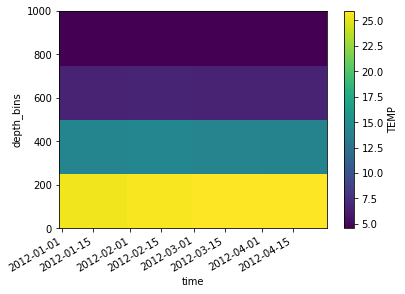

In [23]:
depth_bins = np.arange(0, 1000 + 250, 250)
zmean = data.groupby_bins('depth', depth_bins).mean(dim='depth')
print(zmean)
bins = zmean['depth_bins'].values

plt.figure()
zmean['TEMP'].plot()
plt.show()

## Creating NetCDF

An easy way to write a NetCDF is to create a `DataSet` object.

In [24]:
import numpy as np
from cftime import utime

nx = 10
ny = 20
ntime = 5
x = np.arange(nx)
y = np.arange(ny)

data = np.random.rand(ntime, ny, nx) - 0.5
data = np.ma.masked_where(data < 0, data)

# converts time into date
time = np.arange(ntime)
date = utime('days since 1900-01-01 00:00:00').num2date(time)

First, init an empty `Dataset` object by calling the [xarray.Dataset](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.html)method.

In [25]:
ds = xr.Dataset()

Then, add to the dataset the variables and coordinates. Note that they should be provided as a tuple that contains two elements:
- A list of dimension names
- The numpy array

In [26]:
print(time.shape)
print(data.shape)

ds['data'] = (['time', 'y', 'x'], data)
ds['x'] = (['x'], x)
ds['y'] = (['y'], y)
ds['time'] = (['time'], date)

(5,)
(5, 20, 10)


Then, add the dataset and variable attributes as follows:

In [27]:
import os
from datetime import datetime

# Set file global attributes (file directory name + date)
ds.attrs['script'] = os.getcwd()
ds.attrs['date'] = str(datetime.today())

ds['data'].attrs['description'] = 'Random draft'

Finally, create the NetCDF file by using the [to_netcdf](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.to_netcdf.html) method.

In [28]:
ds.to_netcdf('data/example.nc', unlimited_dims='time', format='NETCDF4')

Note that xarray automatically writes the `_FillValue` attribute and the `time:units` attributes.